In [258]:
# This is the first Kaggle competition that I'm participating in for the sake of applyiny what I have learned from the Kaggle micro-courses.
# Hence, most of this code with not be mine since I am looking at highly-ranked Kaggle notebooks with in-depth, beginner-friendly explanations/walkthroughs.
# Credits:
#       Regularized Linear Models - https://www.kaggle.com/apapiu/regularized-linear-models/comments
#       https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f

In [259]:
# Importing packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from keras.layers import Dense
from keras.models import Sequential
from keras.regularizers import l1
from sklearn.preprocessing import StandardScaler


In [260]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
# print(train.head())
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))
# matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({'price':train['SalePrice'], "log(price + 1)":np.log1p(train["SalePrice"])})
# prices.hist()
#plt.show()

train["SalePrice"] = np.log1p(train["SalePrice"])

numerical_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numerical_feats].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.75].index
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

all_data = pd.get_dummies(all_data)
all_data = all_data.fillna(all_data.mean())

X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [261]:
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y, scoring='neg_mean_squared_error', cv=5))
    return rmse

In [262]:
# model_ridge = Ridge() <-- I don't think we need this Ridge model...
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha=alpha)).mean() for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index=alphas)
# cv_ridge.plot(title= "Determining the best alpha parameter")
# plt.xlabel("alpha")
# plt.ylabel("rmse")
# plt.show()

print("Cross-validation RMSE of this Ridge Linear Model: {}".format(cv_ridge.min()))

Cross-validation RMSE of this Ridge Linear Model: 0.12733734668670763


In [263]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)
print("Cross-validation RMSE of this Lasso Linear Model: {}".format(rmse_cv(model_lasso).mean()))
coef = pd.Series(model_lasso.coef_, index=X_train.columns)
print(f"Lasso picked {sum(coef != 0)} variables and eliminated the other {sum(coef == 0)} variables")
imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])
# matplotlib.rcParams['figure.figsize'] = (14.0, 8.0)
# imp_coef.plot(kind = "barh")
# plt.title("Coefficients in the Lasso Model")
# plt.show()

Cross-validation RMSE of this Lasso Linear Model: 0.12256735885048142
Lasso picked 110 variables and eliminated the other 178 variables


<AxesSubplot:xlabel='preds', ylabel='residuals'>

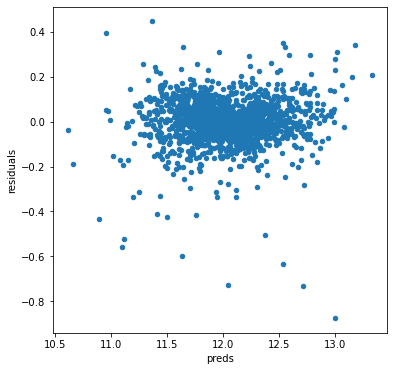

In [264]:
matplotlib.rcParams['figure.figsize'] = (6.0,6.0)
preds = pd.DataFrame({'preds':model_lasso.predict(X_train), 'true':y})
preds['residuals'] = preds['true'] - preds['preds']
preds.plot(x = 'preds', y = 'residuals', kind='scatter')
# plt.show()

In [265]:
# Predicting on the test set
lasso_predictions = np.expm1(model_lasso.predict(X_test))
# my_submission = pd.DataFrame({'Id': test.Id, 'SalePrice':lasso_predictions})
# my_submission.to_csv('Submissions.csv', index=False)

In [266]:
# dtrain = xgb.DMatrix(X_train, label = y)
# dtest = xgb.DMatrix(X_test)

In [267]:
# enhanced_train = pd.concat([X_train, y], axis=1)
X_train_split, X_valid, y_train, y_valid = train_test_split(X_train, y, test_size=.1, random_state=42)

dtrain = xgb.DMatrix(X_train_split, label = y_train)
dvalid = xgb.DMatrix(X_valid, label = y_valid)

In [268]:
# *** Everything in this comment block was from the "Regularized Linear Models" Kaggle Notebook
# params = {'max_depth':2, 'eta':0.1}
# xgb_model = xgb.cv(params, dtrain, num_boost_round=500, early_stopping_rounds=10)
# xgb_model.loc[30:,['test-rmse-mean', 'train-rmse-mean']].plot()
# print(xgb_model[['test-rmse-mean']].idxmin())

In [269]:
params = {
    'max_depth':6,
    'min_child_weight': 1,
    'eta': .3,
    'subsample': 1,
    'colsample_bytree':1,
    'eval_metric': 'rmse'
}
# model_xgb = xgb.train(
#     params,
#     dtrain,
#     num_boost_round=5000,
#     evals=[(dvalid, "Validation")],
#     early_stopping_rounds=10
# )

In [270]:
d_train_total = xgb.DMatrix(pd.concat([X_train_split, X_valid], axis=0), label = pd.concat([y_train, y_valid], axis=0))
cv_results = xgb.cv(
    params,
    dtrain=d_train_total,
    num_boost_round=5000,
    seed=42,
    nfold=5,
    metrics={'rmse'},
    early_stopping_rounds=10
)
cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,8.079669,0.003442,8.079647,0.021118
1,5.663843,0.002373,5.663778,0.020672
2,3.972685,0.001632,3.972629,0.017922
3,2.789096,0.001101,2.789007,0.017881
4,1.960882,0.000691,1.962748,0.017192
...,...,...,...,...
80,0.013292,0.001026,0.140036,0.018884
81,0.012927,0.001018,0.140031,0.018840
82,0.012640,0.001057,0.139982,0.018862
83,0.012302,0.000999,0.139968,0.018836


In [271]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(1,10)
    for min_child_weight in range(1,10)
]

### I tried creating the function below to simply parameter optimization, but it never worked. I am leaving it here so I can come back to it at some point.

In [272]:
# def optimal_parameter(params, gridsearch_params, param1_type, param2_type):
#     params = params
#     param1_name = f'{param1_type}'.split('_')[0]
#     param2_name = f'{param2_type}'.split('_')[0]
#     min_rmse = float("Inf")
#     best_params = None
#     for param1, param2 in gridsearch_params:
#         print("CV with {} = {}, {} = {}".format(param1_name, param1, param2_name, param2)       
#         params[param1_name] = param1
#         params[param2_name] = param2

#         cv_results = xgb.cv(
#             params,
#             dtrain=d_train_total,
#             num_boost_round= 5000,
#             seed=42,
#             nfold=5,
#             metrics = {'rmse'},
#             early_stopping_rounds=10
#         )

#         mean_rmse = cv_results['test-rmse-mean'].min()
#         boost_rounds = cv_results['test-rmse-mean'].argmin()
#         print('\tRMSE {} for {} rounds'.format(mean_rmse, boost_rounds))
#         if mean_rmse < min_rmse:
#             min_rmse = mean_rmse
#             best_params = (param1, param2)

#     print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))

In [273]:
min_rmse = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth = {}, min_child_weight = {}".format(max_depth,                         min_child_weight))
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight

    cv_results = xgb.cv(
        params,
        dtrain=d_train_total,
        num_boost_round= 5000,
        seed=42,
        nfold=5,
        metrics = {'rmse'},
        early_stopping_rounds=10
    )

    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print('\tRMSE {} for {} rounds'.format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth, min_child_weight)

print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))

CV with max_depth = 1, min_child_weight = 1
	RMSE 0.1418312 for 136 rounds
CV with max_depth = 1, min_child_weight = 2
	RMSE 0.1426422 for 136 rounds
CV with max_depth = 1, min_child_weight = 3
	RMSE 0.13706179999999998 for 153 rounds
CV with max_depth = 1, min_child_weight = 4
	RMSE 0.132761 for 324 rounds
CV with max_depth = 1, min_child_weight = 5
	RMSE 0.136169 for 202 rounds
CV with max_depth = 1, min_child_weight = 6
	RMSE 0.13615059999999998 for 228 rounds
CV with max_depth = 1, min_child_weight = 7
	RMSE 0.13846719999999998 for 172 rounds
CV with max_depth = 1, min_child_weight = 8
	RMSE 0.1400446 for 149 rounds
CV with max_depth = 1, min_child_weight = 9
	RMSE 0.137832 for 212 rounds
CV with max_depth = 2, min_child_weight = 1
	RMSE 0.1357814 for 63 rounds
CV with max_depth = 2, min_child_weight = 2
	RMSE 0.1365684 for 65 rounds
CV with max_depth = 2, min_child_weight = 3
	RMSE 0.12944079999999997 for 145 rounds
CV with max_depth = 2, min_child_weight = 4
	RMSE 0.1308347999999

In [274]:
params['max_depth'] = 3
params['min_child_weight'] = 4

In [275]:
gridsearch_params = [
    (subsample, colsample_bytree)
    for subsample in [i/10. for i in range(1, 11)]
    for colsample_bytree in [i/10. for i in range(1, 11)]
]

In [276]:
min_rmse = float("Inf")
best_params = None
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample = {}, colsample = {}".format(subsample, colsample))
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample

    cv_results = xgb.cv(
        params,
        dtrain=d_train_total,
        num_boost_round= 5000,
        seed=42,
        nfold=5,
        metrics = {'rmse'},
        early_stopping_rounds=10
    )

    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print('\tRMSE {} for {} rounds'.format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (subsample, colsample)

print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))

CV with subsample = 1.0, colsample = 1.0
	RMSE 0.12749680000000002 for 137 rounds
CV with subsample = 1.0, colsample = 0.9
	RMSE 0.13129819999999998 for 152 rounds
CV with subsample = 1.0, colsample = 0.8
	RMSE 0.1303704 for 98 rounds
CV with subsample = 1.0, colsample = 0.7
	RMSE 0.1314164 for 110 rounds
CV with subsample = 1.0, colsample = 0.6
	RMSE 0.130531 for 112 rounds
CV with subsample = 1.0, colsample = 0.5
	RMSE 0.12902080000000002 for 119 rounds
CV with subsample = 1.0, colsample = 0.4
	RMSE 0.13178479999999998 for 84 rounds
CV with subsample = 1.0, colsample = 0.3
	RMSE 0.13238980000000003 for 99 rounds
CV with subsample = 1.0, colsample = 0.2
	RMSE 0.130969 for 183 rounds
CV with subsample = 1.0, colsample = 0.1
	RMSE 0.1344044 for 153 rounds
CV with subsample = 0.9, colsample = 1.0
	RMSE 0.130966 for 91 rounds
CV with subsample = 0.9, colsample = 0.9
	RMSE 0.13398880000000002 for 70 rounds
CV with subsample = 0.9, colsample = 0.8
	RMSE 0.1294414 for 118 rounds
CV with subs

In [277]:
params['subsample'] = 1.0
params['colsample_bytree'] = 1.0

In [278]:
%time

min_rmse = float("Inf")
best_params = None
for eta in [.3,.2,.1,.05,.01,.005]:
    print("CV with eta = {}".format(eta))
    params['eta'] = eta

    cv_results = xgb.cv(
        params,
        dtrain=d_train_total,
        num_boost_round= 5000,
        seed=42,
        nfold=5,
        metrics = {'rmse'},
        early_stopping_rounds=10
        )

    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print('\tRMSE {} for {} rounds'.format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = eta

print("Best params: {}, RMSE: {}".format(best_params, min_rmse))

Wall time: 0 ns
CV with eta = 0.3
	RMSE 0.12749680000000002 for 137 rounds
CV with eta = 0.2
	RMSE 0.12903420000000002 for 155 rounds
CV with eta = 0.1
	RMSE 0.1281766 for 204 rounds
CV with eta = 0.05
	RMSE 0.12739060000000002 for 378 rounds
CV with eta = 0.01
	RMSE 0.12701579999999998 for 1813 rounds
CV with eta = 0.005
	RMSE 0.12662980000000001 for 4039 rounds
Best params: 0.005, RMSE: 0.12662980000000001


In [279]:
params['eta'] = .005

In [280]:
num_boost_round = 2295
model_xgb = xgb.train(
    params,
    dtrain,
    num_boost_round = num_boost_round,
    evals=[(dvalid, "Validation")],
    early_stopping_rounds=10
)

1264
[1650]	Validation-rmse:0.11263
[1651]	Validation-rmse:0.11262
[1652]	Validation-rmse:0.11261
[1653]	Validation-rmse:0.11260
[1654]	Validation-rmse:0.11258
[1655]	Validation-rmse:0.11257
[1656]	Validation-rmse:0.11254
[1657]	Validation-rmse:0.11254
[1658]	Validation-rmse:0.11252
[1659]	Validation-rmse:0.11251
[1660]	Validation-rmse:0.11250
[1661]	Validation-rmse:0.11249
[1662]	Validation-rmse:0.11248
[1663]	Validation-rmse:0.11247
[1664]	Validation-rmse:0.11245
[1665]	Validation-rmse:0.11245
[1666]	Validation-rmse:0.11242
[1667]	Validation-rmse:0.11240
[1668]	Validation-rmse:0.11239
[1669]	Validation-rmse:0.11239
[1670]	Validation-rmse:0.11237
[1671]	Validation-rmse:0.11234
[1672]	Validation-rmse:0.11233
[1673]	Validation-rmse:0.11232
[1674]	Validation-rmse:0.11231
[1675]	Validation-rmse:0.11229
[1676]	Validation-rmse:0.11228
[1677]	Validation-rmse:0.11225
[1678]	Validation-rmse:0.11224
[1679]	Validation-rmse:0.11223
[1680]	Validation-rmse:0.11220
[1681]	Validation-rmse:0.11219
[16

In [281]:
dtrain = xgb.DMatrix(X_test)
XGB_predictions = np.expm1(model_xgb.predict(dtrain))
my_submission = pd.DataFrame({'Id': test.Id, 'SalePrice':XGB_predictions})
my_submission.to_csv('SubmissionsXGB.csv', index=False)

<AxesSubplot:xlabel='xgb', ylabel='lasso'>

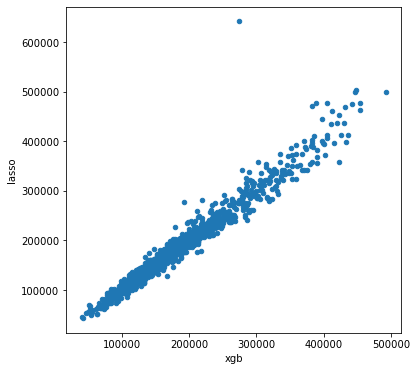

In [282]:
similarity_preds = pd.DataFrame({'xgb': XGB_predictions, 'lasso':lasso_predictions})
similarity_preds.plot(x='xgb', y='lasso', kind='scatter')

In [283]:
preds = 0.7*lasso_predictions + 0.3*XGB_predictions
XGB_with_lasso_preds = pd.DataFrame({'id':test.Id, 'SalePrice':preds})
XGB_with_lasso_preds.to_csv('SubmissionsXGBLasso.csv', index=False)

In [284]:
X_train = StandardScaler().fit_transform(X_train)

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y, random_state=3)

In [287]:
model = Sequential()